In [19]:
import os
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

In [20]:
inputs_path = os.path.join(os.path.dirname(os.getcwd()), "data", "inputs")

# load fred description and data
des_fred_df = pd.read_csv(os.path.join(inputs_path, 'fredmd_description.csv'), sep=";")
fred_df = pd.read_csv(os.path.join(inputs_path, 'fredmd_transf.csv'))
fred_df["date"] = pd.to_datetime(fred_df["date"])
fred_df.set_index("date", inplace=True)
raw_fred_df = pd.read_csv(os.path.join(inputs_path, 'fredmd_raw.csv'))
raw_fred_df["date"] = pd.to_datetime(raw_fred_df["date"])
raw_fred_df.set_index("date", inplace=True)

In [21]:
# chek for missing values
fred_df.apply(lambda x: x.dropna().first_valid_index()).sort_values()

RPI             1960-01-01
T5YFFM          1960-01-01
T1YFFM          1960-01-01
TB6SMFFM        1960-01-01
TB3SMFFM        1960-01-01
                   ...    
VIXCLSx         1962-07-01
ANDENOx         1968-03-01
TWEXAFEGSMTHx   1973-02-01
UMCSENTx        1978-02-01
ACOGNO          1992-03-01
Length: 127, dtype: datetime64[ns]

In [22]:
delete_groups = ["Interest and Exchange Rates", "Stock Market"]
delete_series = ["ACOGNO", "UMCSENTx", "TWEXAFEGSMTHx"]

# delete groups
macro_fred = []
for colname in fred_df.columns:

    if colname not in des_fred_df["fred"].values:
        continue

    group = des_fred_df[des_fred_df["fred"] == colname]["group"].values[0]

    if (group not in delete_groups) and (colname not in delete_series):
        macro_fred.append(fred_df[colname])
macro_fred_df = pd.concat(macro_fred, axis=1)

In [23]:
# chek for missing values
macro_fred_df.apply(lambda x: x.dropna().first_valid_index()).sort_values()

RPI               1960-01-01
CONSPI            1960-01-01
NONREVSL          1960-01-01
REALLN            1960-01-01
BUSLOANS          1960-01-01
                     ...    
UEMP15OV          1960-01-01
UEMP5TO14         1960-01-01
MANEMP            1960-01-01
DSERRG3M086SBEA   1960-01-01
ANDENOx           1968-03-01
Length: 96, dtype: datetime64[ns]

### 1) Daily Macro Features

In [24]:
# parameters
k = 4

# select data
X = macro_fred_df.dropna()

# compute cosine distance = 1 - cosine similarity
X_similarity = cosine_distances(X)

<AxesSubplot:>

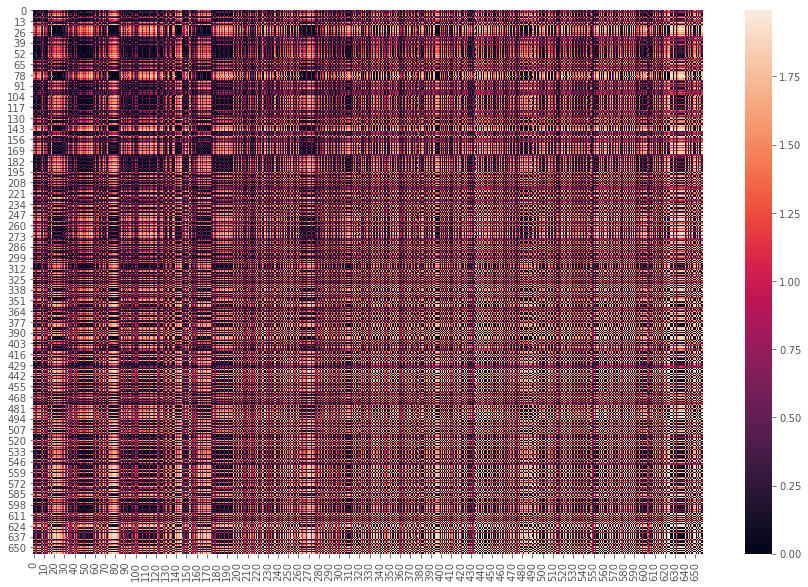

In [25]:
plt.figure(figsize=(15, 10))
sns.heatmap(X_similarity)

In [26]:
kmeans = KMeans(n_clusters=k, random_state=0).fit(X_similarity)
X.loc[:, "cluster"] = kmeans.labels_

melt_X = X[["cluster"]].reset_index().melt("date").drop(["variable"], axis=1)
melt_X.rename(columns={"value": "cluster"}, inplace=True)
melt_X.loc[:, "value"] = 1
melt_X.loc[:, "value"] = melt_X["value"] * melt_X["cluster"]
pivot_X = melt_X.pivot_table(index=["date"], columns=["cluster"], values=["value"])
pivot_X.index = pd.to_datetime(pivot_X.index)

No handles with labels found to put in legend.


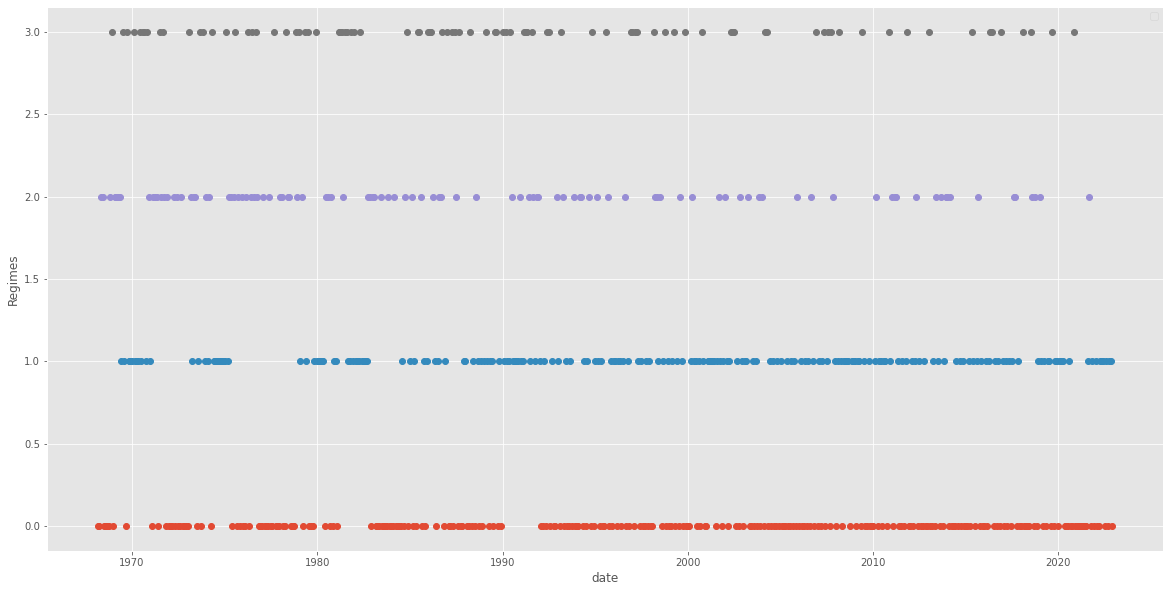

In [27]:
plt.figure(figsize=(20, 10))
plt.plot(pivot_X.index, pivot_X.values, marker="o", linestyle="")
plt.xlabel("date")
plt.ylabel("Regimes")
plt.legend()

In [28]:
regimes_df = pivot_X.copy()
regimes_df.columns = regimes_df.columns.droplevel(0)
snp_regimes_df = pd.concat([regimes_df, raw_fred_df[["S&P 500"]].pct_change().dropna()], axis=1)

pd.DataFrame(snp_regimes_df.reset_index(drop=True).melt("S&P 500").dropna().groupby("variable")["S&P 500"].mean() * 100)

,S&P 500
variable,
0,0.917724
1,0.198661
2,0.844157
3,0.603637


### 2) Rolling Windows of the Macro Features

In [29]:
# parameters
k = 4
window = 12

# select data
X = macro_fred_df.rolling(window=window).mean().dropna()

# compute similarity
X_similarity = cosine_distances(X)

<AxesSubplot:>

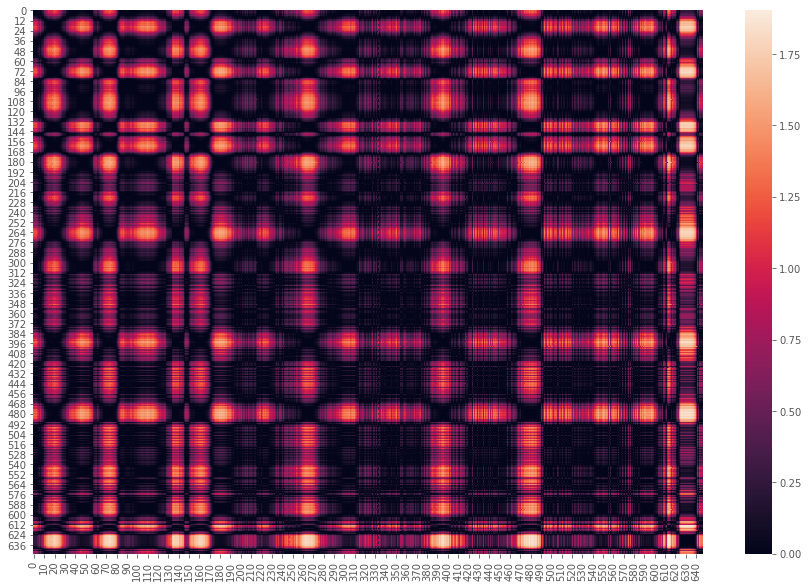

In [30]:
plt.figure(figsize=(15, 10))
sns.heatmap(X_similarity)

In [31]:
kmeans = KMeans(n_clusters=k, random_state=0).fit(X_similarity)
X.loc[:, "cluster"] = kmeans.labels_

melt_X = X[["cluster"]].reset_index().melt("date").drop(["variable"], axis=1)
melt_X.rename(columns={"value": "cluster"}, inplace=True)
melt_X.loc[:, "value"] = 1
melt_X.loc[:, "value"] = melt_X["value"] * melt_X["cluster"]
pivot_X = melt_X.pivot_table(index=["date"], columns=["cluster"], values=["value"])
pivot_X.index = pd.to_datetime(pivot_X.index)

No handles with labels found to put in legend.


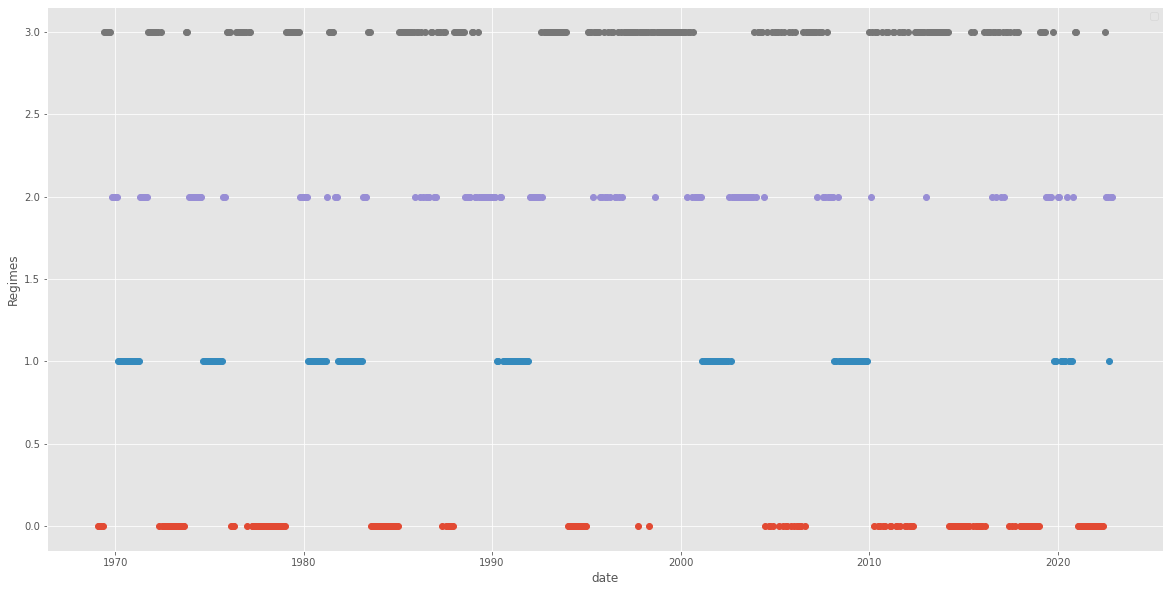

In [32]:
plt.figure(figsize=(20, 10))
plt.plot(pivot_X.index, pivot_X.values, marker="o", linestyle="")
plt.xlabel("date")
plt.ylabel("Regimes")
plt.legend()

In [33]:
regimes_df = pivot_X.copy()
regimes_df.columns = regimes_df.columns.droplevel(0)
snp_regimes_df = pd.concat([regimes_df, raw_fred_df[["S&P 500"]].pct_change().dropna()], axis=1)

pd.DataFrame(snp_regimes_df.reset_index(drop=True).melt("S&P 500").dropna().groupby("variable")["S&P 500"].mean() * 100)

,S&P 500
variable,
0,0.145746
1,0.337079
2,0.433759
3,1.265989


### 3) EW Windows of the Macro Features

In [68]:
# parameters
k = 5
halflife = 6

# select data
X = macro_fred_df.ewm(halflife=halflife).mean().dropna()

# compute similarity
X_similarity = cosine_distances(X)

<AxesSubplot:>

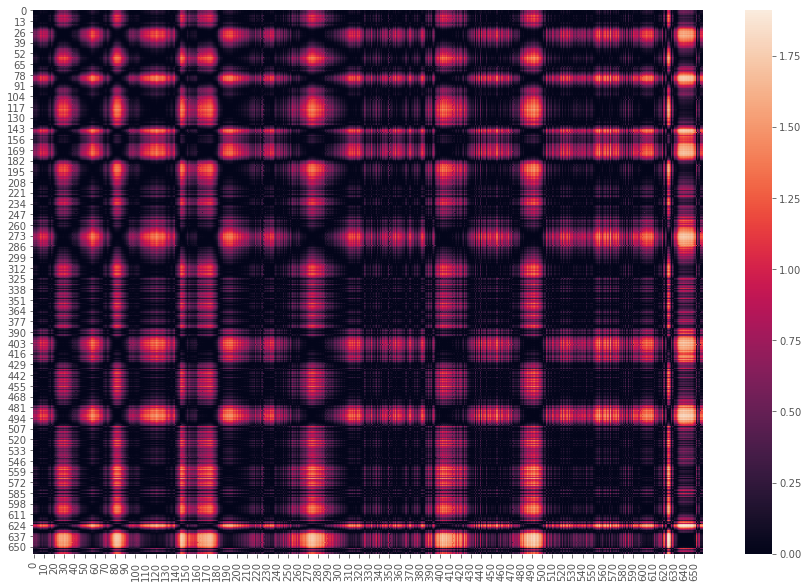

In [69]:
plt.figure(figsize=(15, 10))
sns.heatmap(X_similarity)

In [70]:
kmeans = KMeans(n_clusters=k, random_state=0).fit(X_similarity)
X.loc[:, "cluster"] = kmeans.labels_

melt_X = X[["cluster"]].reset_index().melt("date").drop(["variable"], axis=1)
melt_X.rename(columns={"value": "cluster"}, inplace=True)
melt_X.loc[:, "value"] = 1
melt_X.loc[:, "value"] = melt_X["value"] * melt_X["cluster"]
pivot_X = melt_X.pivot_table(index=["date"], columns=["cluster"], values=["value"])
pivot_X.index = pd.to_datetime(pivot_X.index)

No handles with labels found to put in legend.


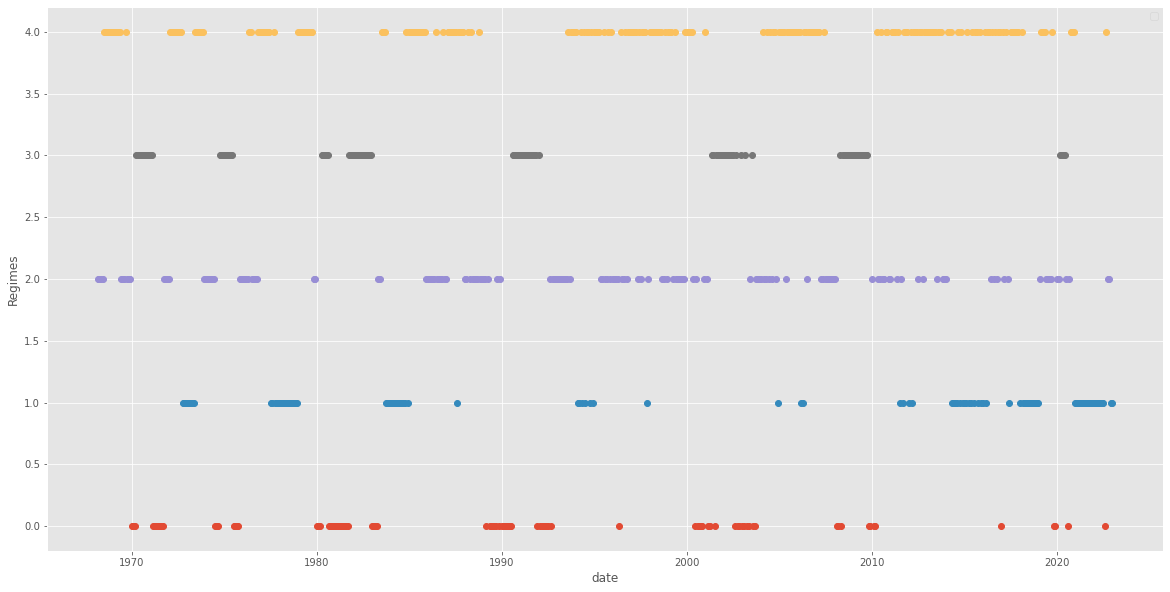

In [71]:
plt.figure(figsize=(20, 10))
plt.plot(pivot_X.index, pivot_X.values, marker="o", linestyle="")
plt.xlabel("date")
plt.ylabel("Regimes")
plt.legend()

No handles with labels found to put in legend.


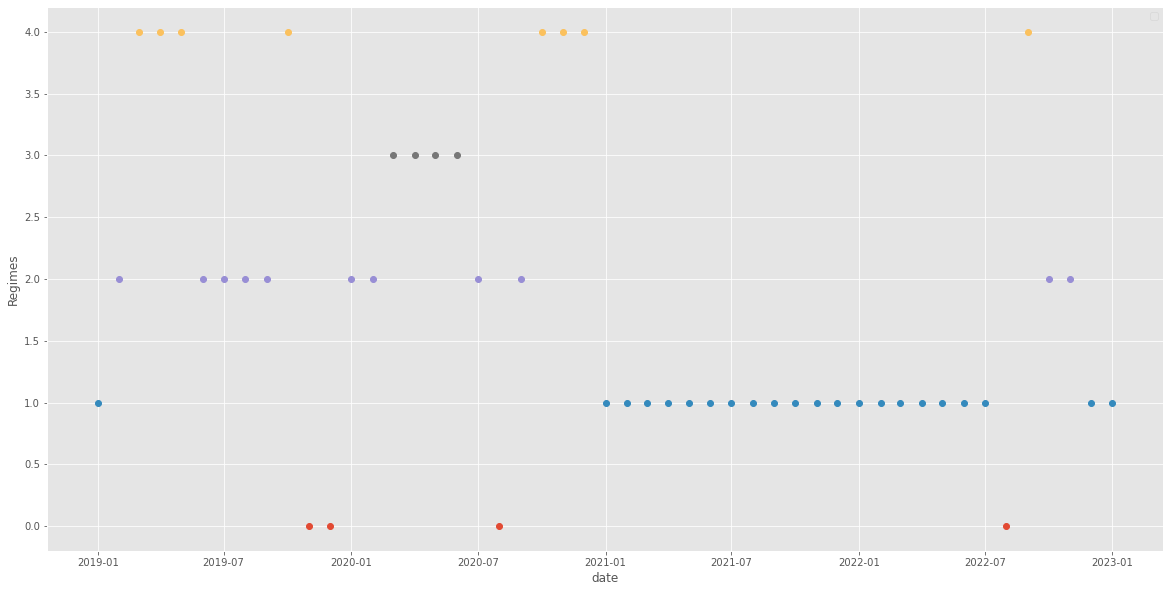

In [72]:
plt.figure(figsize=(20, 10))
plt.plot(pivot_X.loc["2019-01-01":].index, pivot_X.loc["2019-01-01":].values, marker="o", linestyle="")
plt.xlabel("date")
plt.ylabel("Regimes")
plt.legend()

In [38]:
regimes_df = pivot_X.copy()
regimes_df.columns = regimes_df.columns.droplevel(0)
snp_regimes_df = pd.concat([regimes_df, raw_fred_df[["S&P 500"]].pct_change().dropna()], axis=1)

pd.DataFrame(snp_regimes_df.reset_index(drop=True).melt("S&P 500").dropna().groupby("variable")["S&P 500"].mean() * 100)

,S&P 500
variable,
0,0.175818
1,0.306056
2,0.990177
3,0.460762
4,0.828454


### Raw macro features

In [64]:
# parameters
k = 5
halflife = 3

# select data
X = macro_fred_df.ewm(halflife=halflife).mean().dropna()

In [65]:
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
X.loc[:, "cluster"] = kmeans.labels_

melt_X = X[["cluster"]].reset_index().melt("date").drop(["variable"], axis=1)
melt_X.rename(columns={"value": "cluster"}, inplace=True)
melt_X.loc[:, "value"] = 1
melt_X.loc[:, "value"] = melt_X["value"] * melt_X["cluster"]
pivot_X = melt_X.pivot_table(index=["date"], columns=["cluster"], values=["value"])
pivot_X.index = pd.to_datetime(pivot_X.index)

No handles with labels found to put in legend.


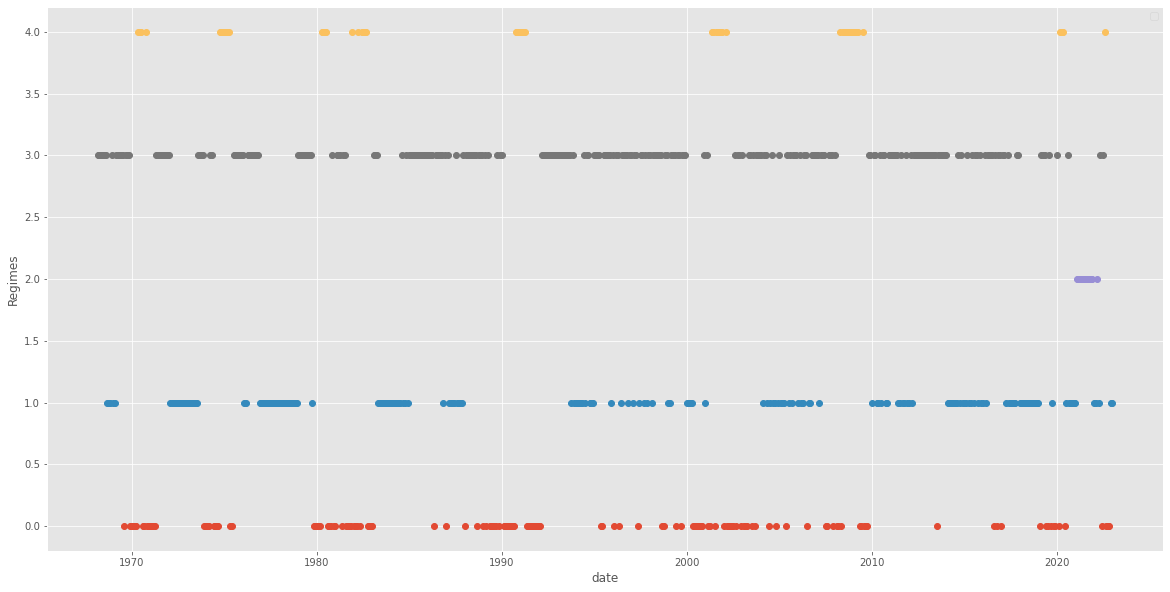

In [66]:
plt.figure(figsize=(20, 10))
plt.plot(pivot_X.index, pivot_X.values, marker="o", linestyle="")
plt.xlabel("date")
plt.ylabel("Regimes")
plt.legend()

No handles with labels found to put in legend.


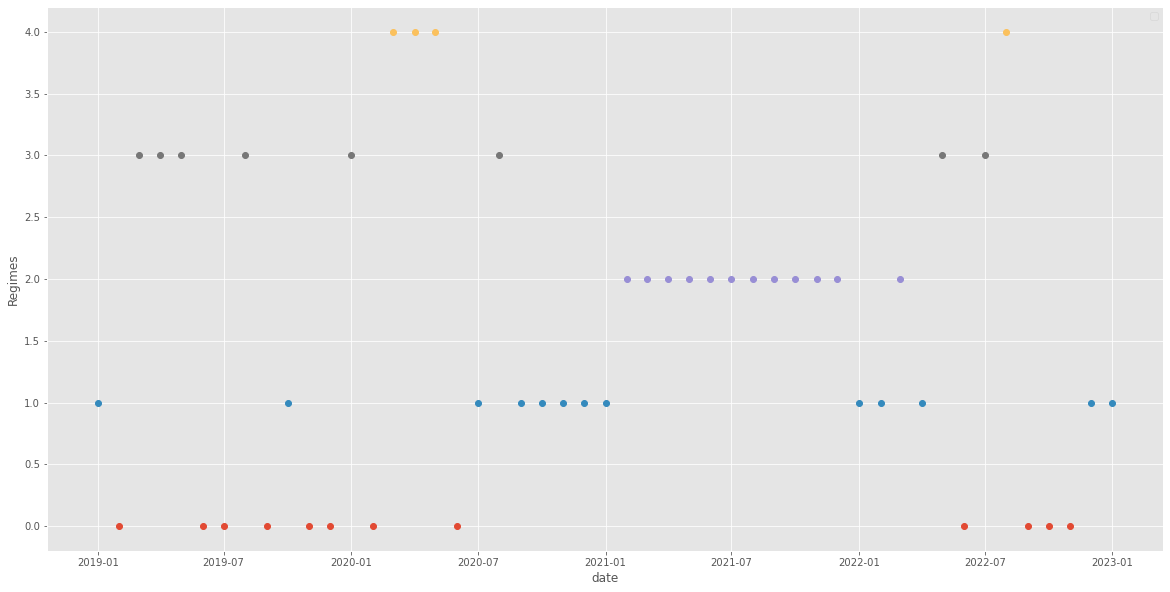

In [67]:
plt.figure(figsize=(20, 10))
plt.plot(pivot_X.loc["2019-01-01":].index, pivot_X.loc["2019-01-01":].values, marker="o", linestyle="")
plt.xlabel("date")
plt.ylabel("Regimes")
plt.legend()

### Kmeans from similarity intuition

In [15]:
# matrix (n x n)
# centroids (k x n)
# for iter=1:max_iter:
## for i=1:n:
### for j=1:n:
#### distance = d(matrix[i, j], centroid) => distance (k x n)
#### mins = argmin(distance) => mins (1 x n)
## update centroids

matrix = X_similarity
n = matrix.shape[0]

centroids = matrix[np.random.choice(n, k, replace=False)]

In [18]:
matrix[np.random.choice(n, k, replace=False)].shape

(4, 647)

In [52]:
pd.DataFrame(centroids, columns=X.index).T.tail()

,0,1,2,3,4
date,,,,,
2022-09-01,0.905963,0.016276,0.494612,0.018263,0.677462
2022-10-01,0.583614,0.128896,0.238859,0.135276,0.384001
2022-11-01,0.464272,0.203247,0.158023,0.211258,0.282965
2022-12-01,1.265110,0.017792,0.833425,0.014909,1.034034
2023-01-01,1.265336,0.017782,0.833650,0.014956,1.034271


In [78]:
pd.DataFrame(matrix[0,:])

,0
0,0.000000
1,0.002473
2,0.001714
3,0.000299
4,0.010523
...,...
654,0.017150
655,0.011722
656,0.041251
657,0.145850


In [74]:
pd.DataFrame(matrix[0,:] - centroids, columns=X.index).T.tail()

,0,1,2,3,4
date,,,,,
2022-09-01,-0.888813,0.000874,-0.477462,-0.001113,-0.660311
2022-10-01,-0.571893,-0.117175,-0.227137,-0.123554,-0.372279
2022-11-01,-0.423022,-0.161996,-0.116772,-0.170007,-0.241715
2022-12-01,-1.119260,0.128058,-0.687575,0.130941,-0.888184
2023-01-01,-1.119368,0.128186,-0.687682,0.131012,-0.888303


In [85]:
# centroids is broadcasted to match matrix[:, np.newaxis] dimension (n x 1 x n)
clusters = np.argmin(np.linalg.norm(matrix[:, np.newaxis] - centroids, axis=2), axis=1)

In [86]:
clusters

array([1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 4, 4, 0, 0, 0, 0, 0, 4, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,
       1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 2, 2, 2, 4, 0, 0, 4, 4, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 4,
       4, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 4, 4, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 2, 2,
       4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,

In [87]:
n = matrix.shape[0]  # Number of points
k = centroids.shape[0]  # Number of centroids

# initialize an empty matrix to store distances
distances = np.zeros((n, k))

for i in range(n):  # loop over each month
    for j in range(k):  # loop over each cluster centroid
        # compute the Euclidean distance between the point and the centroid
        distances[i, j] = np.linalg.norm(matrix[i] - centroids[j])

In [102]:
i = 0
j = 0
print(matrix[i].shape)
print(centroids[j].shape)

(659,)
(659,)


In [105]:
matrix[i][:10]

array([0.        , 0.00247265, 0.00171421, 0.00029947, 0.01052291,
       0.02060945, 0.0349887 , 0.09946812, 0.0772247 , 0.03500429])

In [106]:
centroids[i][:10]

array([0.72546971, 0.79363483, 0.78200394, 0.74864274, 0.86742267,
       0.92527988, 0.98713664, 1.17080345, 1.11713442, 0.9871737 ])

In [97]:
pd.DataFrame(distances, index=X.index).tail()

,0,1,2,3,4
date,,,,,
2022-09-01,21.885604,2.476434,14.474627,2.674772,17.800850
2022-10-01,19.133355,6.770831,10.942544,6.957498,14.627159
2022-11-01,17.622234,8.452129,9.222785,8.629864,12.999874
2022-12-01,23.558797,2.820849,17.539683,2.623857,20.213579
2023-01-01,23.559654,2.824405,17.541581,2.627418,20.214991
